In this series, I want to discuss the creation of a small library for training neural networks: `nntrain`. It's based off the excellent [part 2](https://course.fast.ai/) of Practical Deep Learning for Coders by Jeremy Howard, in which from lessons 13 to 18 (roughly) the development of the `miniai` library is discussed.

The library will build upon PyTorch. However, we'll create things as much as possible from scratch to understand how it all works. Once the main functionality of components are implemented and verified, we can use PyTorch's version, mainly for performance reasons and interoperability. This is similar to how things are done in the course. I explicitly want to state here that it's not just a "copy / paste" of the course. On many occasions I take a different route, and most of the code is my own.

As we'll see, the library will be built using [`nb_dev`](https://nbdev.fast.ai/), another great project from the fastai community. With this software, it becomes very straight forward to create python libraries which are exported from jupyter notebooks. This may sound a bit weird, but it has the advantage that we can create the sourcecode for our library in the very same environment in which we want to experiment and interact with our methods, objects and structure **while we are building the library**. For more details on why this is a good idea, see [here](https://www.fast.ai/posts/2022-07-28-nbdev2.html).

So without further ado, let's start with some data!

## Data

 To keep things simple, let's use the fashion-mnist dataset. We can get the data from the huggingface datasets library:

In [ ]:
from datasets import load_dataset,load_dataset_builder

name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [ ]:
ds = load_dataset(name, split='train')

Reusing dataset fashion_mnist (/root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


`ds` is a `Dataset` object. These kind of objects appear in many Deep Learning libraries and have two main functionalities: you can index into them and they have a length:

In [ ]:
ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [ ]:
len(ds)

60000

In [ ]:
ds

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

Hugginface datasets (as opposed to PyTorch datasets) also have some properties, in this case `num_rows`, which is the length of the dataset (60000) and `features`, a dictionary giving metadata on what is returned when we index into the dataset:

In [ ]:
ds.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

Let's visualize one single item:

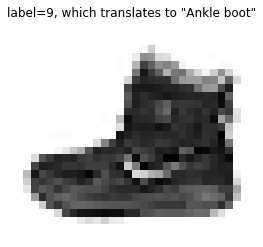

In [ ]:
import matplotlib.pyplot as plt

image = ds[0]['image']
label = ds[0]['label']

figure, axs = plt.subplots()

axs.imshow(ds[0]['image'], cmap='Greys')
axs.set_title(f'Image of the first item in the dataset: label={label} -> "{ds.features["label"].int2str(label)}"');
axs.axis('off');

Since we want to start simple, and only later get to Datsets and Dataloaders: let's pull out the data into a tensor so we can build simple linear layers.

In [ ]:
import torchvision.transforms.functional as TF   # to transform from PIL to tensor
import torch

x_train = [TF.to_tensor(i).view(-1) for i in ds['image']]
y_train = [torch.tensor(i) for i in ds['label']]

len(x_train), len(y_train), len(x_train[0])

(60000, 60000, 784)

So `x_train` and `y_train` are both lists of length 60000, and an element in `x_train` has length 784 (28x28 pixels).

## Linear layers

Now that we have the data, let's create our very first network operation: a linear layer which takes the 784 long flattened out image vector, and maps it to an output vector of length 10

In [ ]:
import torch

def lin(x, a, b):
    return x@a + b

a = torch.randn(784, 10)
b = torch.randn(10)

out = lin(x_train[0], a, b)
out.shape

torch.Size([10])

:::{.callout-note}
For details on matrix multiplications, check out this [post](https://lucasvw.github.io/posts/04_matmul/) I wrote earlier. 
:::

Let's do the same for all our training data at once:

In [ ]:
x_train = torch.stack(x_train)
out = lin(x_train, a,b)
out.shape

torch.Size([60000, 10])

Nice, that's basically a forward pass through our model on all our training data! 

Now if we want to increase the depth of our network by adding an additional layer, we need to add a non-linearity in the middle. Why? See for example the first paragraphs of this [answer](https://stats.stackexchange.com/a/335972). 

Let's add a ReLu nonlinearity:

In [ ]:
def relu(x):
    return x.clamp_min(0.0)

And let's combine these into our first "model", consisting of two linear layers and a relu nonlinearity in the middle:

In [ ]:
n_in = 784 # number of input units (28x28)
n_h = 50   # number of hidden units
n_out = 10 # number of output units

w1 = torch.randn(n_in, n_h)
b1 = torch.zeros(n_h)
w2 = torch.randn(n_h, n_out)
b2 = torch.zeros(n_out)

def model(x):
    a1 = lin(x, w1, b1)
    z1 = relu(a1)
    return lin(z1, w2, b2)

In [ ]:
out = model(x_train)

In [ ]:
out.shape

torch.Size([60000, 10])

Our "model" currently only does a forward pass through the network. And as a matter of fact, it's doing a forward pass with random weights. When training a neural network, we want to change these parameters in a way that the outputs of the network align with the outputs (`y_train`). I will not go into the details of this, but here is a great [video](https://youtu.be/VMj-3S1tku0) by Andrej Karpathy which in my opinion gives one of the best explanations into how this works.

Before doing a backward pass, we first have to calculate the loss. Since the outputs represent any of the 10 classes the image corresponds with,  cross entropy is a straight forward loss function. Some details about cross entropy loss can be found in a [post](https://lucasvw.github.io/posts/05_crossentropy/) I wrote earlier. However, since we want to add the backpropagation ourselves and I don't know how to backpropagate through cross entropy (and I don't feel like spending a lot of time on it), let's use a much easier loss function for now: mean squared error (MSE). This obviously doesn't make any sense in the context of our data, but mathematically it's possible. We just have to end up with a single activation of our model instead of 10:

In [ ]:
n_out = 1  # number of output units changed to 1

w2 = torch.randn(n_h, n_out)
b2 = torch.zeros(n_out)

def model(x):
    a1 = lin(x, w1, b1)
    z1 = relu(a1)
    return lin(z1, w2, b2)

out = model(x_train)

In [ ]:
out.shape

torch.Size([60000, 1])

From which we see that the outputs have an empty trailing dimension. `y_train` doesn't have this, so we have to squeeze out this empty dimension when computing the MSE:

In [ ]:
def mse(pred, targ): 
    return (pred.squeeze(-1)-targ).pow(2).mean() 

y_train = torch.stack(y_train)
mse(out, y_train)

tensor(757.6417)

The next step will be to add the backward pass. But let's refactor our code to put things into classes, that way the backward pass can be added more easily:

In [ ]:
class Linear():
    def __init__(self, n_in, n_out):
        self.w = torch.randn(n_in, n_out)
        self.b = torch.zeros(n_out)
    
    def __call__(self, x):
        self.inp = x                      # storing this for the backward pass
        self.out = x@self.w + self.b      # storing this for the backward pass
        return self.out
    
class Relu():
    def __call__(self, x):
        self.inp = x                      # storing this for the backward pass
        self.out = x.clamp_min(0.)        # storing this for the backward pass
        return self.out
    
class MSE():
    def __call__(self, pred, targ):
        self.pred = pred                   # storing this for the backward pass
        self.targ = targ                   # storing this for the backward pass
        self.out = (pred.squeeze(-1)-targ).pow(2).mean()
        return self.out
    
class Model():
    def __init__(self, n_in, n_h, n_out):
        self.layers = [Linear(n_in, n_h), Relu(), Linear(n_h, n_out)]
        self.loss = MSE()
        
    def __call__(self, x, y):
        for l in self.layers: x = l(x)
        return self.loss(x, y)

In [ ]:
x_train.shape

torch.Size([60000, 784])

In [ ]:
m = Model(n_in, n_h, n_out)
l = m(x_train, y_train)

To add in the functionality for the backward pass, redefining the whole class is a nuisance. So instead we'll `patch` the classes. We can do this very easily by using the `fastcore` library. Let's see a small example:

In [ ]:
import fastcore.all as fc

class A():
    def hi(self): print('hello 😎')
    
a = A()
a.hi()

@fc.patch
def hi(self:A): print('howdy 🤠')

a.hi()

hello 😎
howdy 🤠


So with `fc.patch` we can extend or change the behavior of Classes that have been defined elsewhere, even on instances of the objects that are already created. Nice!

In [ ]:
@fc.patch
def backward(self: Linear):
    self.inp.g = self.out.g @ self.w.t()
    self.w.g = self.inp.t() @ self.out.g
    self.b.g = self.out.g.sum(0)
    
@fc.patch
def backward(self: Relu):
    self.inp.g = (self.inp>0).float() * self.out.g
    
@fc.patch
def backward(self: MSE):
    self.pred.g = 2. * (self.pred.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]
    
@fc.patch
def backward(self: Model):
    self.loss.backward()
    for l in reversed(self.layers): l.backward()

In [ ]:
m = Model(n_in, n_h, n_out)
l = m(x_train, y_train)
m.backward()

Now the actual operations in the backward methods you will just have to take for granted as I am not going to derive them. If you want, you can have some fun (?) to try and derive it yourself. What I think is most important about these formulas:

1. Notice that each layer has a reference to it's inputs and it's outputs
2. During the backward pass, each layer uses the gradient from the *outputs* and uses it to set the gradient on the *inputs*
3. The inputs from layer $n$ are the outputs from layer $n-1$, so when the gradients are being set on the inputs from layer $n$, this means that layer $n-1$ it's outputs are being set at the same time
4. This is the fundamental point about backpropagation of the gradient: in reverse order, layer by layer the gradients are being *propagated back* through the network using the chain rule
5. Although we don't derive the operations, we can see that that there *exist* operations that do this. These operations are not magical, they are just the result of calculus: not very different from the fact that if $f(x) = x^2$ then $f'(x) = 2x$ and if $h(x) = f(g(x))$ then $h'(x) = f'(g(x)) * g'(x)$

## First refactor: `Module` baseclass and training loop

Now let's see how we can make this a little better. One thing that seems a bit silly is that in each of the `Linear`, `MSE` and `Relu` classes, we are storing explicitly the inputs and outputs when doing a forward call. As mentioned, we need this to backpropagate the gradients. However, we rather not store that explicitly all the time when creating a new layer. 

So let's create a base class that takes care of this:

- Pack the forward functionality of each layer in a dedicated `forward` method
- let the storing of inputs and ouputs be done in the `__call__` method of the baseclass, and call the `self.forward` method in between.

This works, but there is one caveat: most layers just have one input when they are called (`x`), but the loss has 2 (`pred` and `targ`). To make this storing of the inputs generic we can store them as an array on the base class, and also pass them as positional arguments to `_backward`. This way, `forward` and `_backward` have the same arguments.

In [ ]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def backward(self): self._backward(*self.args)

    
class Linear(Module):
    def __init__(self, n_in, n_out):
        self.w = torch.randn(n_in, n_out)
        self.b = torch.zeros(n_out)
    
    def forward(self, x):
        return x@self.w + self.b
    
    def _backward(self, inp):
        inp.g = self.out.g @ self.w.t()
        self.w.g = inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)
    
    
class Relu(Module):
    def forward(self, x):
        return x.clamp_min(0.)
    
    def _backward(self, inp):
        inp.g = (inp>0).float() * self.out.g

    
class MSE(Module):
    def forward(self, pred, targ):
        return (pred.squeeze(-1)-targ).pow(2).mean()
    
    def _backward(self, pred, targ):
        pred.g = 2. * (pred.squeeze() - targ).unsqueeze(-1) / targ.shape[0]
    
    
class Model(Module):
    def __init__(self, n_in, n_h, n_out):
        self.layers = [Linear(n_in, n_h), Relu(), Linear(n_h, n_out)]
        self.loss = MSE()
        
    def forward(self, x, y):
        for l in self.layers: x = l(x)
        return self.loss(x, y)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

With these objects, let's create our first training loop:

In [ ]:
epochs = 5                              # train for nr of epochs
bs     = 1024                           # batch-size
lr     = 0.01                           # learning rate
m = Model(n_in, n_h, n_out)             # instantiate our model

for epoch in range(epochs):             # iterate through epochs
    for i in range(0,len(x_train), bs): # iterate through the batches
        xb = x_train[i:i+bs]            # get minibatch 
        yb = y_train[i:i+bs]
        
        loss = m(xb, yb)                # forward pass
        m.backward()                    # backward pass
        
        for l in m.layers:              # iterate through the layers
            if isinstance(l, Linear):   # only update the linear layers
                l.w += - lr * l.w.g     # update the weights
                l.b += - lr * l.b.g     # update the bias

                l.w.g = None            # reset the gradients
                l.b.g = None
    print(f'{epoch=} | {loss=:.1f}')

epoch=0 | loss=106694101172224.0
epoch=1 | loss=9835971084288.0
epoch=2 | loss=906763501568.0
epoch=3 | loss=83593175040.0
epoch=4 | loss=7706321408.0


Awesome, the loss is decreasing i.e. the model is training!

## Second refactor: simplify the weight update

Let's try to simplify our training loop, and make it more generic. By adding functionality to our Module class so that it has a reference to it's trainable parameters, we can update the weights as shown below.

In [ ]:
def fit(epochs):
    for epoch in range(epochs):
        for i in range(0,len(x_train), bs):
            xb = x_train[i:i+bs]
            yb = y_train[i:i+bs]

            loss = m(xb, yb)
            m.backward()

            for p in m.parameters():    # model has a reference to the trainable parameters
                p -= lr * p.g           
            m.zero_grad()               # model can reset the gradients
        print(f'{epoch=} | {loss=:.1f}')

To do so, we will create a new baseclass (`NNModule`), from which our model and all the layers will inherit. We have the following conditions and properties:

1. The class will hold a dictionary `_named_args`, in which all the named arguments are stored that are set on the Module.
2. This is done by defining a `__setattr__` method, which stores any named argument that doesn't start with an `_` in this dictionary
3. For the `Linear`, these named arguments will be the parameters `w` and `b`
4. For the `Model`, these named arguments will be `layers` (an array containing the layer objects) and `loss` containing the `MSE` object.
5. Because we want to get the parameters directly out of a layer, as well as out of the model, we need to implement some logic in `_parameters()` to iterate through the lowest "level" and get the actual parameters out
6. Last but not least we have to implement a `zero_grad()` method to zero the gradients on the parameters

In [ ]:
class NNModule:
    def __init__(self):
        self._named_args = {}                           # [1]
        
    def __setattr__(self, name, value):                 # [2]
        if not name.startswith("_"): self._named_args[name] = value
        super().__setattr__(name, value)
        
    def _parameters(self, obj):                         # [5]
        for i in obj:
            if isinstance(i, torch.Tensor): yield i
            if isinstance(i, NNModule):
                yield from iter(self._parameters(i._named_args.values()))
            if isinstance(i, list):
                yield from iter(self._parameters(i))
        
    def parameters(self):
        return list(self._parameters(self._named_args.values()))
    
    def zero_grad(self):
        for p in self.parameters():
            p.g = None                                   # [6]
        
    def __call__(self, *args):
        self._args = args                                # NOT stored under _named_args as \
        self._out = self.forward(*args)                  # it starts with "_"
        return self._out
    
    def backward(self): self._backward(*self._args)

In [ ]:
class Linear(NNModule):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = torch.randn(n_in, n_out)               # [3] stored under _named_args 
        self.b = torch.zeros(n_out)                     # [3] stored under _named_args
    
    def forward(self, x):
        return x@self.w + self.b
    
    def _backward(self, inp):
        inp.g = self._out.g @ self.w.t()
        self.w.g = inp.t() @ self._out.g
        self.b.g = self._out.g.sum(0)
        
        
class Relu(NNModule):
    def forward(self, x):
        return x.clamp_min(0.)
    
    def _backward(self, inp):
        inp.g = (inp>0).float() * self._out.g

    
class MSE(NNModule):
    def forward(self, pred, targ):
        return (pred.squeeze(-1)-targ).pow(2).mean()
    
    def _backward(self, pred, targ):
        pred.g = 2. * (pred.squeeze() - targ).unsqueeze(-1) / targ.shape[0]
        
        
class Model(NNModule):
    def __init__(self, n_in, n_h, n_out):
        super().__init__()
        self.layers = [Linear(n_in, n_h), Relu(), Linear(n_h, n_out)]
        self.loss = MSE()                              # [4] < and ^ are stored under _named_args
        
    def forward(self, x, y):
        for l in self.layers: x = l(x)
        return self.loss(x, y)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

And now we can indeed call `parameters` on both the model as well as on individual layers:

In [ ]:
m = Model(n_in, n_h, n_out)
[p.shape for p in m.parameters()]

[torch.Size([784, 50]), torch.Size([50]), torch.Size([50, 1]), torch.Size([1])]

In [ ]:
[p.shape for p in Linear(n_in, n_h).parameters()]

[torch.Size([784, 50]), torch.Size([50])]

Let's fit with our new training loop:

In [ ]:
fit(5)

epoch=0 | loss=346.2
epoch=1 | loss=39.9
epoch=2 | loss=11.3
epoch=3 | loss=8.6
epoch=4 | loss=8.3


## Third refactor: use `nn.Module`

Finally we are in a position to use PyTorch's `nn.Module`, since we understand all of it's behavior! We can simplify:

In [ ]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, n_in, n_h, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_out)]
        for i,l in enumerate(self.layers):               # ^ we use the nn.Linear and nn.ReLU from PyTorch
            self.add_module(f'layer_{i}', l)             # we need to register the modules explicitly
        self.loss = nn.MSELoss()                         # we use the MSELoss from PyTorch
        
    def forward(self, x, y):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze(-1), y)

In [ ]:
# Autograd needs all tensors to be float
x_train = x_train.to(torch.float32)
y_train = y_train.to(torch.float32)
m = Model(n_in, n_h, n_out)

In [ ]:
def fit(epochs):
    for epoch in range(epochs):
        for i in range(0,len(x_train), bs):
            xb = x_train[i:i+bs]
            yb = y_train[i:i+bs]

            loss = m(xb, yb)
            loss.backward()

            with torch.no_grad():
                for p in m.parameters():
                    p -= lr * p.grad
                m.zero_grad()
        print(f'{epoch=} | {loss=:.1f}')

## Fourth refactor: `nn.ModuleList` and `nn.Sequential`

To simplify the storing of the layers array and the registration of the modules, we can use `nn.ModuleList`. Let's also take out the loss out of the model itself, and put that in the `fit` function:

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, n_h, n_out):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(n_in, n_h), nn.ReLU(), nn.Linear(n_h, n_out)])
        
    def forward(self, x, y):
        for l in self.layers: x = l(x)
        return x

This turns out to be such an elementary operation, that PyTorch has a module for it: `nn.Sequential`. 

In [ ]:
import torch.nn.functional as F

layers = [nn.Linear(n_in,n_h), nn.ReLU(), nn.Linear(n_h, n_out)]
model = nn.Sequential(*layers)

And let's update our training loop as we mentioned:

- The loss needs to be computed separately, since we took it out of the model
- Let's use cross entropy instead of MSE
- For that we will switch back to using 10 outputs conforming with the 10 categories

In [ ]:
n_out = 10
layers = [nn.Linear(n_in,n_h), nn.ReLU(), nn.Linear(n_h, n_out)]
model = nn.Sequential(*layers)

loss_func = F.cross_entropy
y_train = y_train.to(torch.long)

for epoch in range(epochs):
    for i in range(0,len(x_train), bs):
        xb = x_train[i:i+bs]
        yb = y_train[i:i+bs]

        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()

        with torch.no_grad():
            for p in model.parameters():
                p -= lr * p.grad
            model.zero_grad()
    print(f'{epoch=} | {loss=:.3f}')

epoch=0 | loss=1.702
epoch=1 | loss=1.182
epoch=2 | loss=1.068
epoch=3 | loss=1.003
epoch=4 | loss=0.864


## Fifth refactor: add an Optimizer

We can further refactor the model by adding an Optimizer, this is an object that will have access to the `parameters` and does the updating of the weights (`step`) and zeroing the gradient. Most notably, we want to go from:

In [ ]:
...
with torch.no_grad():
    for p in model.parameters():
        p -= lr * p.grad
    model.zero_grad()
...

to:

In [ ]:
opt.step()
opt.zero_grad()

So that the training loop becomes:

In [ ]:
def fit(epochs):
    for epoch in range(epochs):
        for i in range(0,len(x_train), bs):
            xb = x_train[i:i+bs]
            yb = y_train[i:i+bs]

            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()

            opt.step()                 
            opt.zero_grad()
        print(f'{epoch=} | {loss=:.3f}')

So we introduce the Optimizer, which has exactly these two methods:

In [ ]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= self.lr * p.grad
        
    def zero_grad(self):
        with torch.no_grad():
            for p in self.params: p.grad.zero_()

In [ ]:
layers = [nn.Linear(n_in,n_h), nn.ReLU(), nn.Linear(n_h, n_out)]
model = model = nn.Sequential(*layers)
opt = Optimizer(model.parameters(), lr)

In [ ]:

fit(5)

epoch=0 | loss=0.666
epoch=1 | loss=0.595
epoch=2 | loss=0.493
epoch=3 | loss=0.484
epoch=4 | loss=0.427


The optimizer we just created is basically the `SGD` optimizer from PyTorch so let's use that:

In [ ]:
def get_model():
    layers = [nn.Linear(784,50), nn.ReLU(), nn.Linear(50,10)]
    model = nn.Sequential(*layers)
    
    opt = torch.optim.SGD(model.parameters(), 0.5)
    
    return model, opt

model, opt = get_model()
fit(5)

epoch=0 | loss=0.979
epoch=1 | loss=0.672
epoch=2 | loss=0.499
epoch=3 | loss=0.499
epoch=4 | loss=0.432


## End

We have come a long way, and covered a lot of ground. We have seen many of the fundamental components of training a neural network: the data, a simple model, training loops and optimizers. We have seen why things like `nn.Module` exist, and understand it's behavior. Furthermore, we have seen that the need for `nn.Module` and `torch.optim` comes out of the need for simplifying things.

In the next post, we will get to datasets and dataloaders, and we will start adding our first things into the `nntrain` library 🕺.